# Definitions

In [1]:
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
def check_dims(x, dims):
    x_dims = np.asarray(x).ndim
    if x_dims != dims:
        raise ValueError('Dimension mis-match')

        
def relu(x):
    return np.clip(x, a_min=0, a_max=None)
        
        
def xent_loss(label, prediction):
    check_dims(label, 0)
    check_dims(prediction, 1)
    
    labels_onehot = np.zeros(2)
    labels_onehot[label] = 1
    
    loss = -np.sum(labels_onehot * np.log(prediction))
    return loss


def xent_entropy_regularization_loss(label, prediction, beta):
    check_dims(label, 0)
    check_dims(prediction, 1)
    
    labels_onehot = np.zeros(2)
    labels_onehot[label] = 1
    
    xentropy = -np.sum(labels_onehot * np.log(prediction))
    neg_entropy = np.sum(prediction * np.log(prediction))
    loss = xentropy + beta * neg_entropy
    return loss


def xent_hard_clip_loss(label, prediction, hard_eps):
    check_dims(label, 0)
    check_dims(prediction, 1)
    
    labels_onehot = np.zeros(2)
    labels_onehot[label] = 1
    
    xentropy = -np.sum(labels_onehot * np.log(prediction))
    offset = -np.log(1 - hard_eps)
    loss = relu(xentropy - offset)
    return loss
    
    
def xent_smooth_loss(label, prediction, smooth_eps):
    check_dims(label, 0)
    check_dims(prediction, 1)
    
    labels_onehot = np.zeros(2)
    labels_onehot[label] = 1
    
    smooth_labels = labels_onehot * (1-2*smooth_eps) + smooth_eps

    xentropy = -np.sum(smooth_labels * np.log(prediction))
    offset = -np.sum(smooth_labels * np.log(smooth_labels + 1e-8))
    loss = xentropy - offset
    return loss
    
    
def xent_smooth_clip_loss(label, prediction, smooth_eps):
    check_dims(label, 0)
    check_dims(prediction, 1)
    
    labels_onehot = np.zeros(2)
    labels_onehot[label] = 1
    
    smooth_labels = labels_onehot * (1-2*smooth_eps) + smooth_eps

    xentropy = -np.sum(smooth_labels * np.log(prediction))
    offset = -np.sum(smooth_labels * np.log(smooth_labels + 1e-8))
    loss_tmp = xentropy - offset
    
    mask = np.sum((prediction - labels_onehot) ** 2) > 2 * smooth_eps ** 2
    mask = mask.astype(np.float32)    
    loss = loss_tmp * mask
    
    return loss


def focal_loss(label, prediction, gamma):
    check_dims(label, 0)
    check_dims(prediction, 1)
    
    labels_onehot = np.zeros(2)
    labels_onehot[label] = 1
    
    xentropy = -np.sum(labels_onehot * np.log(prediction))
    proba_correct = np.sum(labels_onehot * prediction)
    loss = ((1.0 - proba_correct) ** gamma) * xentropy
    
    return loss

In [3]:
def plot_with_opt(ax, x, y, label):
    opt_idx = np.argmin(y)
    ax.plot(x, y, label=label, marker='o', markevery=[opt_idx])
    return ax

def prepare_plot(ax, xlim=[-0.01, 1.01], ylim=[None, None]):
    ax.set_xlabel('proba class 1')
    ax.legend(fontsize=9, bbox_to_anchor=(1, 1), loc='upper left')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    return ax

# Different Losses

In [4]:
min_val = 1e-4
n_points = 300
pred = np.linspace(min_val, 1-min_val, num=n_points, endpoint=True, dtype=np.float32)
pred = np.stack([1-pred, pred], axis=1)

## NegEntropy

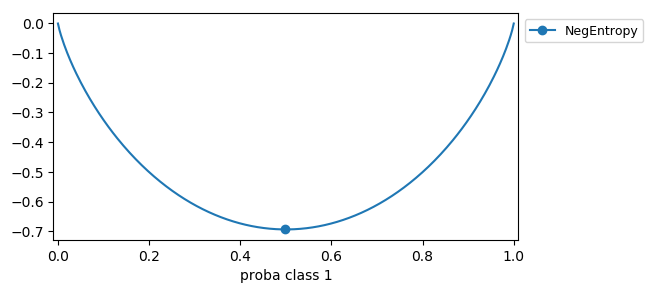

In [5]:
neg_entropy = np.sum(pred * np.log(pred), axis=1)
fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=100)
ax = plot_with_opt(ax, pred[:, 1], neg_entropy, 'NegEntropy')
ax = prepare_plot(ax)
plt.show()

## Cross-entropy

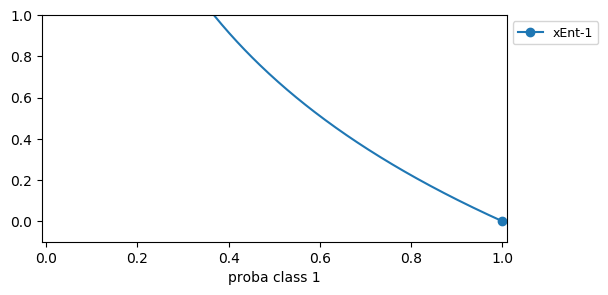

In [6]:
y = 1
loss = np.asarray([
    xent_loss(y, y_hat) 
    for y_hat in pred
])

fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=100)
ax = plot_with_opt(ax, pred[:, 1], loss, 'xEnt-%d' % y)
ax = prepare_plot(ax, ylim=[-0.1, 1])
plt.show()

## Cross-entropy with entropy regularization

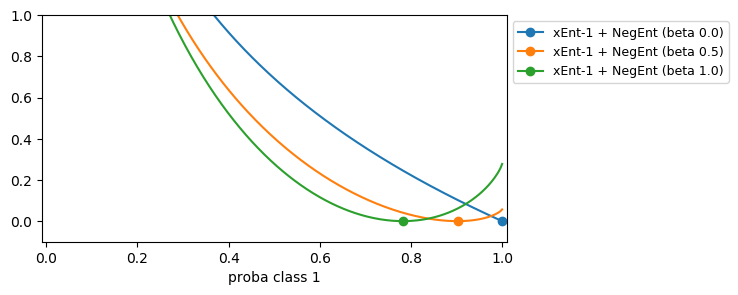

In [7]:
y = 1
beta_list = [0.0, 0.5, 1.0]
min_at_zero = True

fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=100)
for beta in beta_list:
    loss = np.asarray([
        xent_entropy_regularization_loss(y, y_hat, beta) 
        for y_hat in pred
    ])
    loss = loss - loss.min() if min_at_zero else loss
    ax = plot_with_opt(ax, pred[:, 1], loss, 'xEnt-%d + NegEnt (beta %1.1f)' % (y, beta))
ax = prepare_plot(ax, ylim=[-0.1, 1])
plt.show()

## Cross-entropy with soft labels

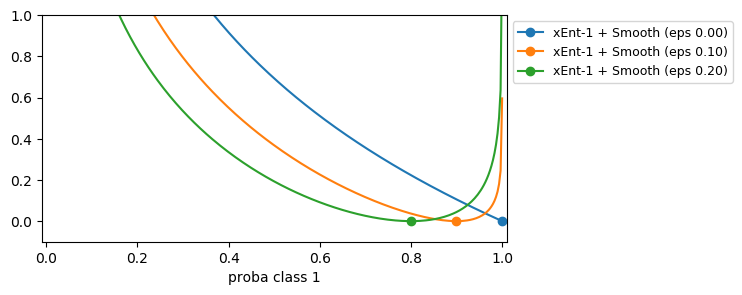

In [8]:
y = 1
smooth_eps_list = [0.0, 0.1, 0.2]

fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=100)
for smooth_eps in smooth_eps_list:
    loss = np.asarray([
        xent_smooth_loss(y, y_hat, smooth_eps) 
        for y_hat in pred
    ])
    ax = plot_with_opt(ax, pred[:, 1], loss, 'xEnt-%d + Smooth (eps %1.2f)' % (y, smooth_eps))
ax = prepare_plot(ax, ylim=[-0.1, 1])
plt.show()

## Focal loss

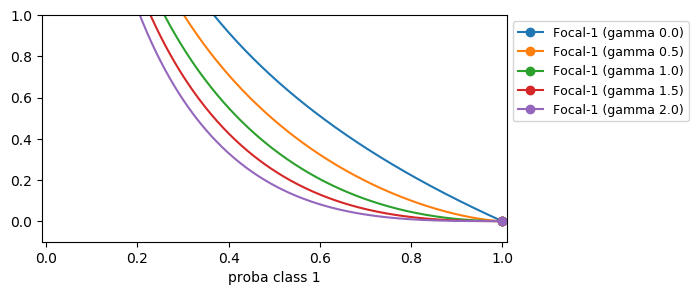

In [9]:
y = 1
gamma_list = [0.0, 0.5, 1.0, 1.5, 2.0]

fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=100)
for gamma in gamma_list:
    loss = np.asarray([
        focal_loss(y, y_hat, gamma) 
        for y_hat in pred
    ])
    ax = plot_with_opt(ax, pred[:, 1], loss, 'Focal-%d (gamma %1.1f)' % (y, gamma))
ax = prepare_plot(ax, ylim=[-0.1, 1])
plt.show()

## Cross-entropy hard clip

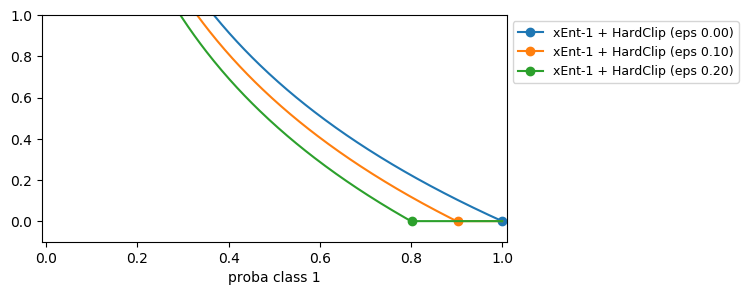

In [10]:
y = 1
hard_eps_list = [0.0, 0.1, 0.2]

fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=100)
for hard_eps in hard_eps_list:
    loss = np.asarray([
        xent_hard_clip_loss(y, y_hat, hard_eps) 
        for y_hat in pred
    ])
    ax = plot_with_opt(ax, pred[:, 1], loss, 'xEnt-%d + HardClip (eps %1.2f)' % (y, hard_eps))
ax = prepare_plot(ax, ylim=[-0.1, 1])
plt.show()

# Cross-entropy smooth clip

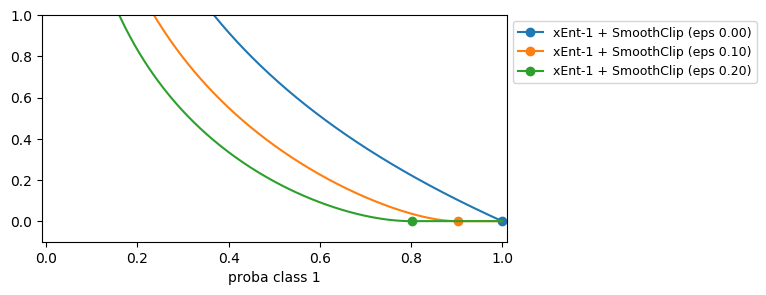

In [11]:
y = 1
smooth_eps_list = [0.0, 0.1, 0.2]

fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=100)
for smooth_eps in smooth_eps_list:
    loss = np.asarray([
        xent_smooth_clip_loss(y, y_hat, smooth_eps) 
        for y_hat in pred
    ])
    ax = plot_with_opt(ax, pred[:, 1], loss, 'xEnt-%d + SmoothClip (eps %1.2f)' % (y, smooth_eps))
ax = prepare_plot(ax, ylim=[-0.1, 1])
plt.show()

# Comparison

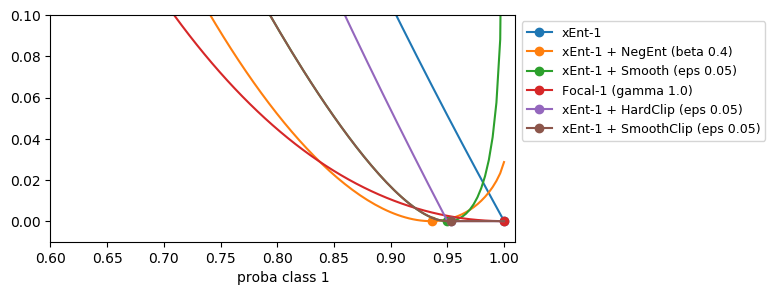

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=100)
y = 1

# beta_eps_gamma = [[], [0.1], []]
beta_eps_gamma = [[0.4], [0.05], [1.0]]
# beta_eps_gamma = [[0.5], [0.1], [1.5]]

# Cross-entropy
loss = np.asarray([
    xent_loss(y, y_hat) 
    for y_hat in pred
])
ax = plot_with_opt(ax, pred[:, 1], loss, 'xEnt-%d' % y)

# Cross-entropy with entropy regularization
beta_list = beta_eps_gamma[0]
min_at_zero = True
for beta in beta_list:
    loss = np.asarray([
        xent_entropy_regularization_loss(y, y_hat, beta) 
        for y_hat in pred
    ])
    loss = loss - loss.min() if min_at_zero else loss
    ax = plot_with_opt(ax, pred[:, 1], loss, 'xEnt-%d + NegEnt (beta %1.1f)' % (y, beta))

# Cross-entropy with soft labels
smooth_eps_list = beta_eps_gamma[1]
for smooth_eps in smooth_eps_list:
    loss = np.asarray([
        xent_smooth_loss(y, y_hat, smooth_eps) 
        for y_hat in pred
    ])
    ax = plot_with_opt(ax, pred[:, 1], loss, 'xEnt-%d + Smooth (eps %1.2f)' % (y, smooth_eps))
    
# Focal loss
gamma_list = beta_eps_gamma[2]
for gamma in gamma_list:
    loss = np.asarray([
        focal_loss(y, y_hat, gamma) 
        for y_hat in pred
    ])
    ax = plot_with_opt(ax, pred[:, 1], loss, 'Focal-%d (gamma %1.1f)' % (y, gamma))

# Cross-entropy hard clip
hard_eps_list = beta_eps_gamma[1]
for hard_eps in hard_eps_list:
    loss = np.asarray([
        xent_hard_clip_loss(y, y_hat, hard_eps) 
        for y_hat in pred
    ])
    tmp_loss = loss
    ax = plot_with_opt(ax, pred[:, 1], loss, 'xEnt-%d + HardClip (eps %1.2f)' % (y, hard_eps))
    
# Cross-entropy smooth clip
smooth_eps_list = beta_eps_gamma[1]
for smooth_eps in smooth_eps_list:
    loss = np.asarray([
        xent_smooth_clip_loss(y, y_hat, smooth_eps) 
        for y_hat in pred
    ])
    ax = plot_with_opt(ax, pred[:, 1], loss, 'xEnt-%d + SmoothClip (eps %1.2f)' % (y, smooth_eps))
    
ax = prepare_plot(ax, xlim=[0.6, 1.01], ylim=[-0.01, 0.1])
plt.show()